In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

def normalize_weather_data(dataset_paths, encoding):
    dfs = []
    
    for index, path in enumerate(dataset_paths):
        dfs.append(pd.read_csv(path, encoding=encoding))

    for index, df in enumerate(dfs):
        dfs[index] = df[["Station Name", "Date (Local Standard Time)", "Air Temp. Avg. (°C)"]]
        
    weather_df = pd.concat(dfs, ignore_index=True)
    
    weather_df[["Month", "Year"]] = weather_df["Date (Local Standard Time)"].str.split(
        "-", expand=True
    )

    weather_df["Month"] = pd.to_datetime(weather_df["Month"], format="%B").dt.month
    weather_df["Year"] = weather_df["Year"].astype(int)
    weather_df["Avg Temp"] = weather_df["Air Temp. Avg. (°C)"].astype(float)

    weather_df = weather_df.drop(columns=["Date (Local Standard Time)", "Air Temp. Avg. (°C)"])
    
    return weather_df

def build_community_crime_data(crime_statistics_dataset_path, wards_dataset_path):
    crime_statistics_df = pd.read_csv(crime_statistics_dataset_path)
    wards_df = pd.read_csv(wards_dataset_path)

    wards_df = wards_df[["NAME", "WARD_NUM"]]
    wards_df.rename(columns={"NAME": "Community", "WARD_NUM": "Ward Number"}, inplace=True)
    
    crime_wards_merged_df = crime_statistics_df.merge(
        wards_df[["Community", "Ward Number"]], on="Community", how="left"
    )
    
    return crime_wards_merged_df

def consolidate_crime_weather_disorder_data(community_crime_df, weather_df, social_disorder_df):
    consolidated_df = community_crime_df.merge(weather_df[['Year', 'Month', 'Avg Temp']], on=['Year', 'Month'], how="left")   
    consolidated_df = consolidated_df.merge(
        social_disorder_df[['Year','Month','Event Count', 'Community']], 
        on=['Year', 'Month', 'Community'], 
        how="left"
    )
    
    consolidated_df["Disorder Count"] = consolidated_df["Event Count"].fillna(0)

    consolidated_df.drop(columns=["Event Count"], inplace=True)

    return consolidated_df

def plot_crime_occurrence_series(df, years_in_view, city=""):
    for year in years_in_view:
        crime_year = df[df["Year"] == year]
        crime_grouped = (
            crime_year.groupby(["Category", "Month"])["Crime Count"].sum().reset_index()
        )

        plt.figure(figsize=(12, 6))

        for category in crime_grouped["Category"].unique():
            subset = crime_grouped[crime_grouped["Category"] == category]
            plt.plot(subset["Month"], subset["Crime Count"], marker="o", label=category)

        plt.xlabel("Month")
        plt.ylabel("Crime Count")
        plt.title(f"Series - Crime Occurrences by Category ({year}) for {city}")
        plt.xticks(range(1, 13))
        plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
        plt.show()

def plot_crime_summary_series_all_years(df, years_in_view, city):
    filtered_df = df[df["Year"].isin(years_in_view)]

    total_crime = (
        filtered_df.groupby(["Category", "Month"])["Crime Count"].sum().reset_index()
    )

    plt.figure(figsize=(12, 6))

    for category in total_crime["Category"].unique():
        subset = total_crime[total_crime["Category"] == category]
        plt.plot(
            subset["Month"],
            subset["Crime Count"],
            marker="o",
            linewidth=2,
            label=f"{category} (Summed)",
        )

    plt.xlabel("Month")
    plt.ylabel(f"{city} Total Crime Count For The Last 5years")
    plt.title(f"Total Crime Occurrences Across {len(years_in_view)} Years for {city}")
    plt.xticks(range(1, 13))
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.show()
        
def plot_crime_occurrence_barchart(df, years_in_view, city=""):
    for year in years_in_view:
        crime_year = df[df["Year"] == year]
        crime_grouped = crime_year.groupby("Category")["Crime Count"].sum().reset_index()

        plt.figure(figsize=(12, 6))

        sns.barplot(
            x="Category",
            y="Crime Count",
            hue="Category",
            data=crime_grouped,
            palette="viridis",
            legend=False  # Remove legend since hue is used for colors
        )

        # Add annotations for each bar
        for index, row in crime_grouped.iterrows():
            plt.text(index, row["Crime Count"] + 2, f"{int(row['Crime Count'])}", 
                     ha="center", fontsize=9, fontweight="bold")

        plt.xlabel("Crime Category")
        plt.ylabel("Total Crime Count")
        plt.title(f" Crime Occurrences by Category ({year}) for {city}")
        plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
        plt.show()

def plot_crime_summary_barchart_all_years(df, years_in_view, city):
    crime_filtered = df[df["Year"].isin(years_in_view)]
    crime_grouped = crime_filtered.groupby("Category")["Crime Count"].sum().reset_index()

    plt.figure(figsize=(12, 6))

    sns.barplot(
        x="Category",
        y="Crime Count",
        hue="Category",
        data=crime_grouped,
        palette="viridis",
        legend=False  # Remove legend since hue is used for colors
    )

    # Add annotations for each bar
    for index, row in crime_grouped.iterrows():
        plt.text(index, row["Crime Count"] + 2, f"{int(row['Crime Count'])}", 
                 ha="center", fontsize=9, fontweight="bold")

    plt.xlabel("Crime Category")
    plt.ylabel("Total Crime Count")
    plt.title(f"{city} Crime Occurrences by Category for the last 5 years")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    plt.show()
    
def convert_month_season(month):
    if month in [0, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"


def plot_seasonal_crime_occurrence_series(df, years_in_view, city=""):
    df_extended = df.copy()
    
    df_extended = df_extended.sort_values(by=["Year", "Month"], ascending=[True, True])
    
    season_months = {
        "Winter": [0, 1, 2],  # December is now 0
        "Spring": [3, 4, 5],
        "Summer": [6, 7, 8],
        "Fall": [9, 10, 11]
    }
    
    # Create Month 0 rows by carrying over December values to the next year
    new_rows = []
    for year in df_extended["Year"].unique():
        df_december = df_extended[(df_extended["Year"] == year) & (df_extended["Month"] == 12)].copy()
        if not df_december.empty:
            df_december["Year"] = year + 1  # Shift to the next year
            df_december["Month"] = 0  # Set Month to 0
            new_rows.append(df_december)
    
    if new_rows:
        df_extended = pd.concat([df_extended] + new_rows, ignore_index=True)
        df_extended = df_extended.sort_values(by=["Year", "Month"], ascending=[True, True])

    
    df_extended["Season"] = df_extended["Month"].apply(convert_month_season)

    for year in sorted(df_extended["Year"].unique())[-5:]:
        df_year = df_extended[df_extended["Year"] == year]
        seasons = ["Winter", "Spring", "Summer", "Fall"]
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
        fig.suptitle(f"{city} Seasonal Crime Trends for {year}", fontsize=16)
        
        for i, season in enumerate(seasons):
            df_season = df_year[df_year["Season"] == season].copy()
            
            df_season["AdjustedMonthCat"] = pd.Categorical(df_season["Month"].astype(int), 
                                                           categories=season_months[season], 
                                                           ordered=True)
    
            df_season = df_season.sort_values("AdjustedMonthCat")
    
            ax = axes[i // 2, i % 2]
            sns.lineplot(ax=ax, data=df_season, x="AdjustedMonthCat", y="Crime Count", marker="o")
            
            ax.set_title(season)
            ax.set_xlabel("Month")
            ax.set_ylabel("Crime Count")
            
            ax.set_xticks(season_months[season])
            ax.set_xticklabels(["Dec", "Jan", "Feb"] if season == "Winter" else 
                               ["Mar", "Apr", "May"] if season == "Spring" else 
                               ["Jun", "Jul", "Aug"] if season == "Summer" else 
                               ["Sep", "Oct", "Nov"])
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


def plot_top_seasonal_crime_occurrence_over_years(df, years_in_view, city=""):
    df_extended = df.copy()
    
    df_extended = df_extended.sort_values(by=["Year", "Month"], ascending=[True, True])
    
    season_months = {
        "Winter": [0, 1, 2],  # December is now 0
        "Spring": [3, 4, 5],
        "Summer": [6, 7, 8],
        "Fall": [9, 10, 11]
    }
    
    # Create Month 0 rows by carrying over December values to the next year
    new_rows = []
    for year in df_extended["Year"].unique():
        df_december = df_extended[(df_extended["Year"] == year) & (df_extended["Month"] == 12)].copy()
        if not df_december.empty:
            df_december["Year"] = year + 1  # Shift to the next year
            df_december["Month"] = 0  # Set Month to 0
            new_rows.append(df_december)
    
    if new_rows:
        df_extended = pd.concat([df_extended] + new_rows, ignore_index=True)
        df_extended = df_extended.sort_values(by=["Year", "Month"], ascending=[True, True])

    
    df_extended["Season"] = df_extended["Month"].apply(convert_month_season)
    
    df_last_5_years = df_extended[df_extended["Year"].isin(years_in_view)]
    
    df_seasonal_crime = (
        df_last_5_years.groupby(["Season", "Category"], as_index=False)["Crime Count"]
        .sum()
    )
    
    top_5_per_season = (
        df_seasonal_crime.groupby("Season", group_keys=False, as_index=False)
        .apply(lambda x: x.nlargest(5, "Crime Count"))
        .reset_index(drop=True)
    )
    
    unique_categories = top_5_per_season["Category"].unique()
    category_palette = sns.color_palette("tab10", n_colors=len(unique_categories))
    category_colors = dict(zip(unique_categories, category_palette))

    
    seasons = ["Winter", "Spring", "Summer", "Fall"]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"{city} Top 5 Recurring Crimes for Each Season (Last 5 Years)", fontsize=16)
    
    for i, season in enumerate(seasons):
        df_season = top_5_per_season[top_5_per_season["Season"] == season]
        ax = axes[i // 2, i % 2]
        
        sns.barplot(
            ax=ax,
            data=df_season,
            x="Crime Count",
            y="Category",
            hue="Category", 
            palette=category_colors,
            legend=False  # Disable legend in subplots
        )
        
        ax.set_title(season)
        ax.set_xlabel("Total Crime Count")
        ax.set_ylabel("Category")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_wards_crime_occurrence_heatmap_over_years(df, years_in_view, city=""):
    df_extended = df.copy()

    df_extended = df_extended[df_extended["Year"].isin(years_in_view)]

    crime_count_by_ward_aggregated_by_year = (df_extended.groupby(['Ward Number', 'Year'])['Crime Count'].sum().reset_index())

    crime_count_by_ward_aggregated_heatmap_data = crime_count_by_ward_aggregated_by_year.pivot(index='Ward Number', columns='Year', values='Crime Count')

    plt.figure(figsize=(12, 6))
    sns.heatmap(crime_count_by_ward_aggregated_heatmap_data, cmap="Blues", linewidths=0.5, annot=True, fmt=".0f")

    plt.xlabel("Year")
    plt.ylabel("Ward Number")
    plt.title(f"{city} Crime Count Frequency by Ward and Year")
    plt.show()

def prepare_city_geo_df(file_path):
    city_geo_df = gpd.read_file(file_path)
    city_geo_df.rename(columns={'ward_num': 'Ward Number'}, inplace=True)
    city_geo_df["Ward Number"] = city_geo_df["Ward Number"].astype(float)
    
    if city_geo_df.crs.is_geographic:
        city_geo_df = city_geo_df.to_crs(epsg=3857)
    
    return city_geo_df

def display_city_crime_geo_data(city_geo_df, crime_df, city):
    crime_summary = crime_df.groupby("Ward Number")["Crime Count"].sum().reset_index()
    
    city_geo_df = city_geo_df.merge(crime_summary, on="Ward Number", how="left")
    
    if city_geo_df.crs.is_geographic:
        city_geo_df = city_geo_df.to_crs(epsg=3857)

    city_geo_df["centroid"] = city_geo_df.geometry.centroid
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    city_geo_df.plot(column="Crime Count", cmap="Reds", linewidth=0.8, edgecolor="black", legend=True, ax=ax)
    
    for idx, row in city_geo_df.iterrows():
        centroid = row["centroid"]
        ax.text(centroid.x, centroid.y, str(int(row["Ward Number"])), fontsize=12, ha='center', color='black')
    
    ax.set_title(f"Crime Count by Ward in {city}")
    
    plt.show()

def plot_city_crime_disorder_relationship(city_crime_disorder_df, city):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=city_crime_disorder_df['Crime Count'], y=city_crime_disorder_df['Disorder Count'], alpha=0.7)
    sns.regplot(x=city_crime_disorder_df['Crime Count'], y=city_crime_disorder_df['Disorder Count'], scatter=False, color='red')
    plt.xlabel('Crime Count')
    plt.ylabel('Disorder Count')
    plt.title(f'{city} Crime vs Disorder Relationship')
    plt.show()


def plot_city_crime_disorder_correlation(city_crime_disorder_df, city):
    corr_matrix = city_crime_disorder_df[['Crime Count', 'Disorder Count']].corr()
    
    plt.figure(figsize=(10,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=2)
    plt.title(f'{city} Correlation Heatmap: Crime vs Disorder')
    plt.show()

In [11]:
calgary_weather_data_one_path = "./datasets/calgary_weather_data_20180101_20220101.csv"
calgary_weather_data_two_path = "./datasets/calgary_weather_data_20220101_20250101.csv"

calgary_weather_df = normalize_weather_data([calgary_weather_data_one_path, calgary_weather_data_two_path], "latin-1")

display(calgary_weather_df.head())

,Station Name,Month,Year,Avg Temp
0,Calgary Int'L CS,1,2018,-6.9
1,Calgary Int'L CS,2,2018,-12.4
2,Calgary Int'L CS,3,2018,-5.8
3,Calgary Int'L CS,4,2018,1.0
4,Calgary Int'L CS,5,2018,14.1


In [12]:
calgary_comuninty_crime_statistics_path = "./datasets/community_crime_statistics_calgary.csv"
calgary_communities_by_ward_path =  "./datasets/communities_by_ward_calgary.csv"

calgary_crime_df = build_community_crime_data(calgary_comuninty_crime_statistics_path, calgary_communities_by_ward_path)

display(calgary_crime_df.head())

,Community,Category,Crime Count,Year,Month,Ward Number
0,01B,Assault (Non-domestic),1,2022,11,1.0
1,01B,Break & Enter - Commercial,1,2019,6,1.0
2,01B,Break & Enter - Commercial,1,2019,8,1.0
3,01B,Break & Enter - Commercial,2,2020,3,1.0
4,01B,Break & Enter - Commercial,2,2020,7,1.0


In [13]:
calgary_community_disorder_statistics_path = "./datasets/community_disorder_statistics_calgary.csv"
calgary_disorder_df = pd.read_csv(calgary_community_disorder_statistics_path)

display(calgary_disorder_df.head())

filtered_df = calgary_disorder_df[(calgary_disorder_df["Year"] == 2020) & (calgary_disorder_df["Month"] == 1)]

,Community,Category,Event Count,Year,Month
0,01B,Disorder,1,2018,2
1,01B,Disorder,2,2018,6
2,01B,Disorder,1,2018,8
3,01B,Disorder,1,2018,10
4,01B,Disorder,2,2018,11


In [14]:
calgary_extended_df = consolidate_crime_weather_disorder_data(calgary_crime_df, calgary_weather_df, calgary_disorder_df)

display(calgary_extended_df.head())

,Community,Category,Crime Count,Year,Month,Ward Number,Avg Temp,Disorder Count
0,01B,Assault (Non-domestic),1,2022,11,1.0,-5.8,0.0
1,01B,Break & Enter - Commercial,1,2019,6,1.0,13.6,1.0
2,01B,Break & Enter - Commercial,1,2019,8,1.0,15.3,1.0
3,01B,Break & Enter - Commercial,2,2020,3,1.0,-4.6,0.0
4,01B,Break & Enter - Commercial,2,2020,7,1.0,16.6,2.0


In [15]:
years_in_view = sorted(calgary_extended_df["Year"].unique())[-5:]

display(years_in_view)

[np.int64(2020),
 np.int64(2021),
 np.int64(2022),
 np.int64(2023),
 np.int64(2024)]

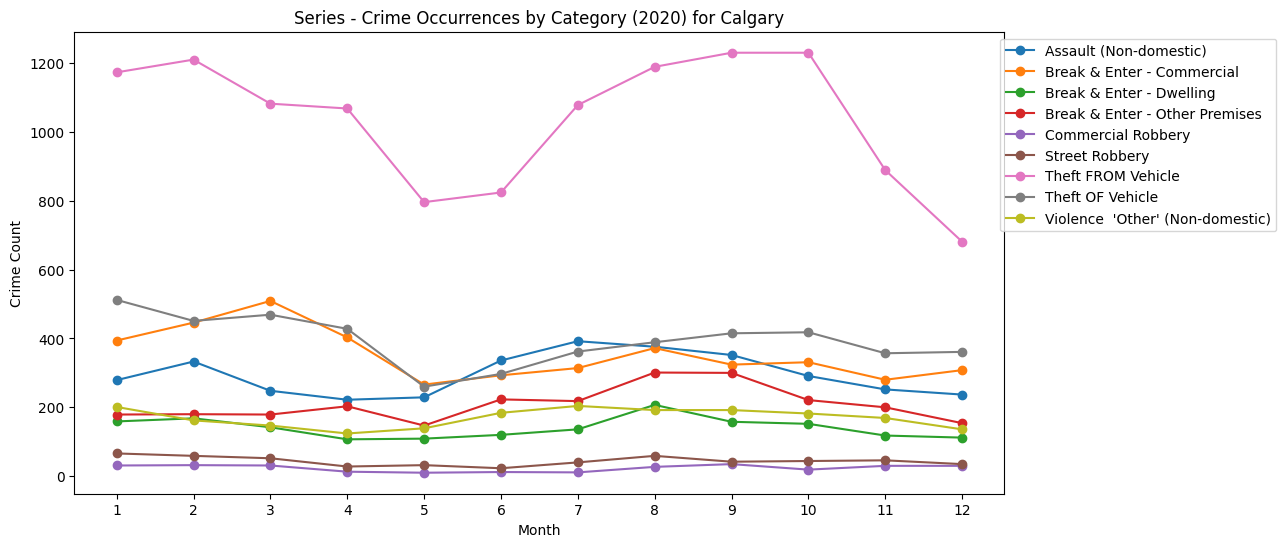

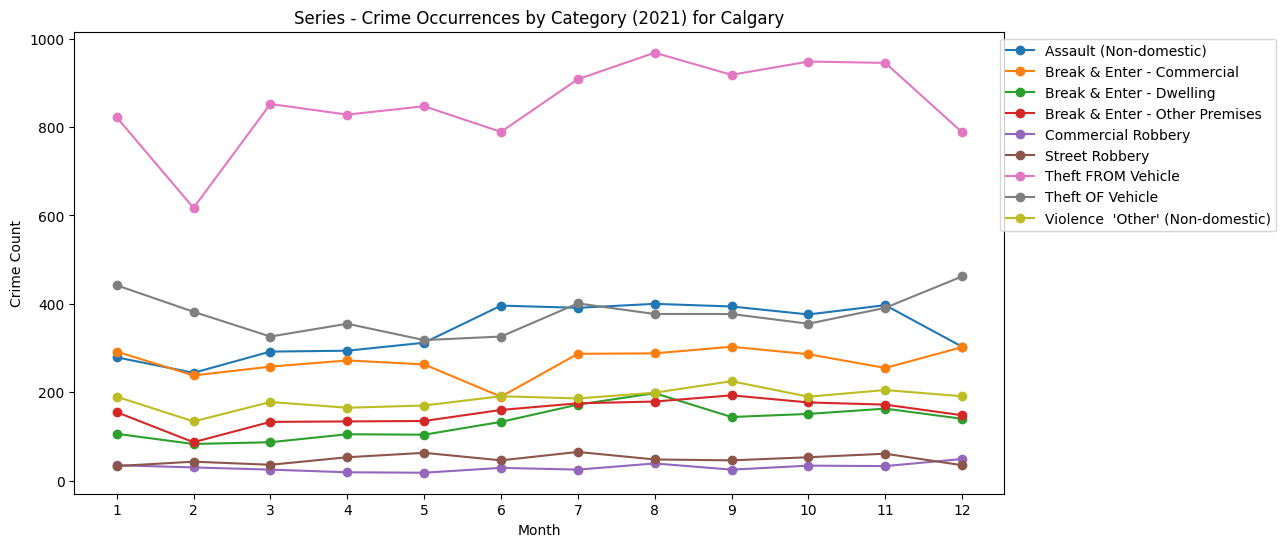

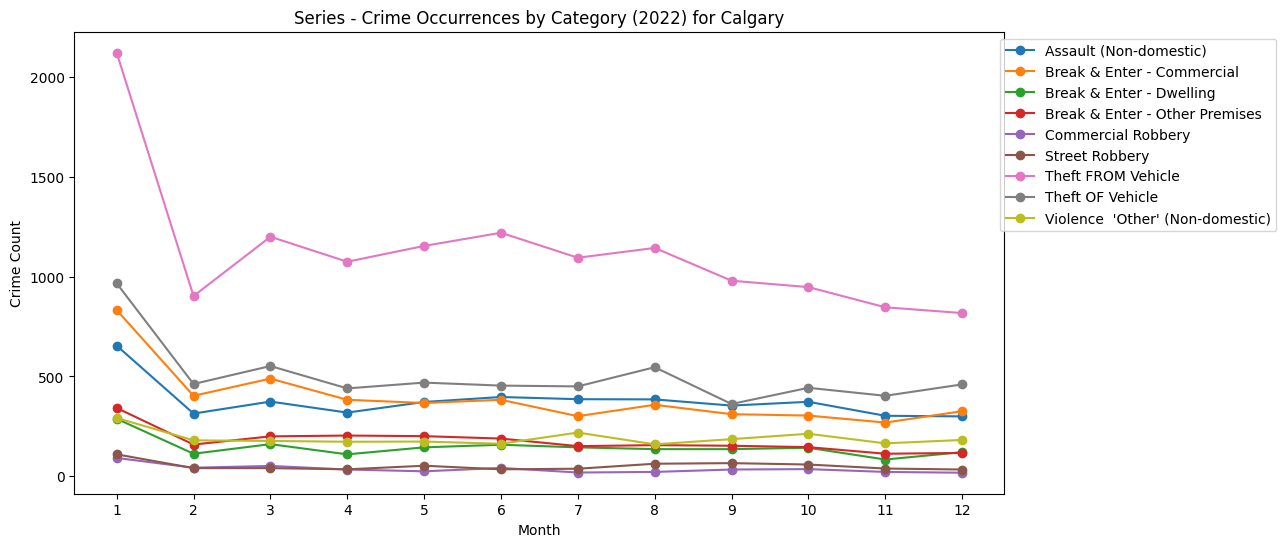

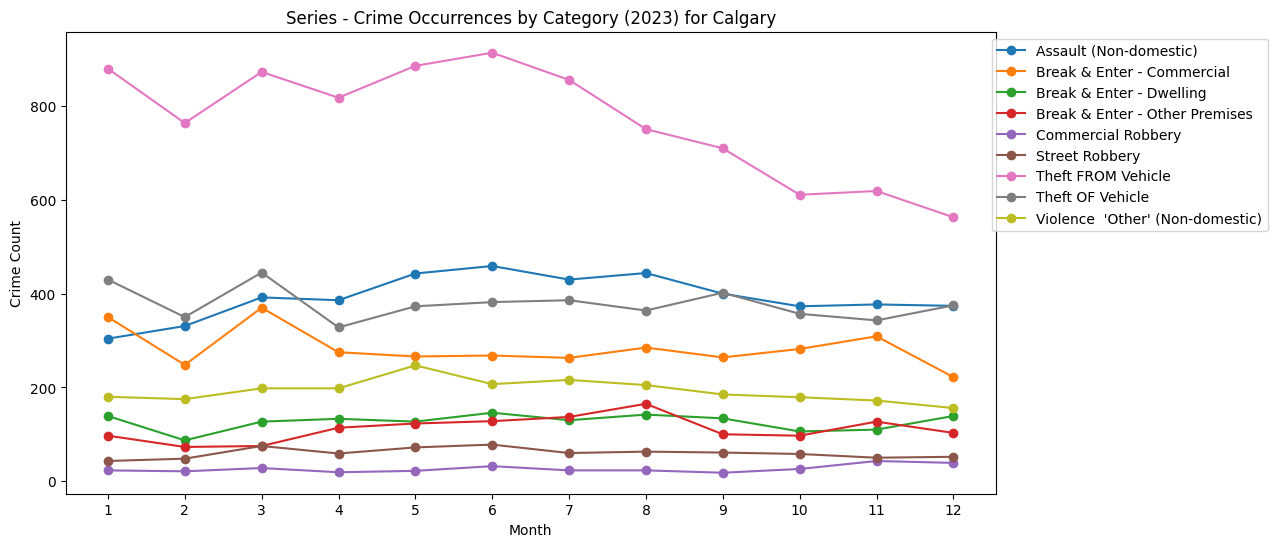

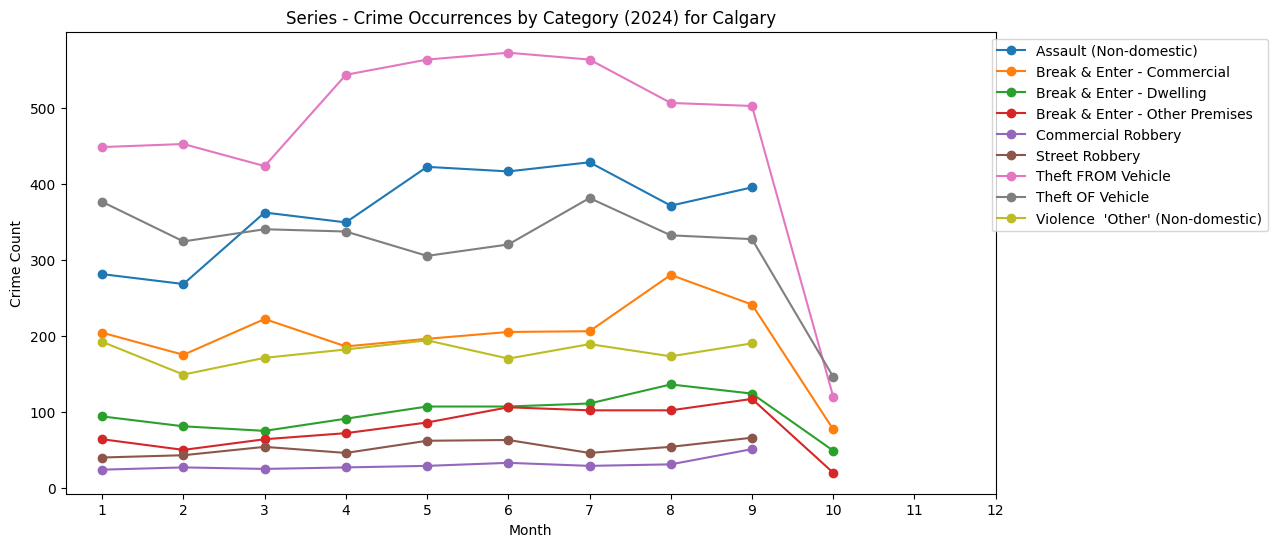

In [16]:
plot_crime_occurrence_series(calgary_extended_df, years_in_view, city="Calgary")


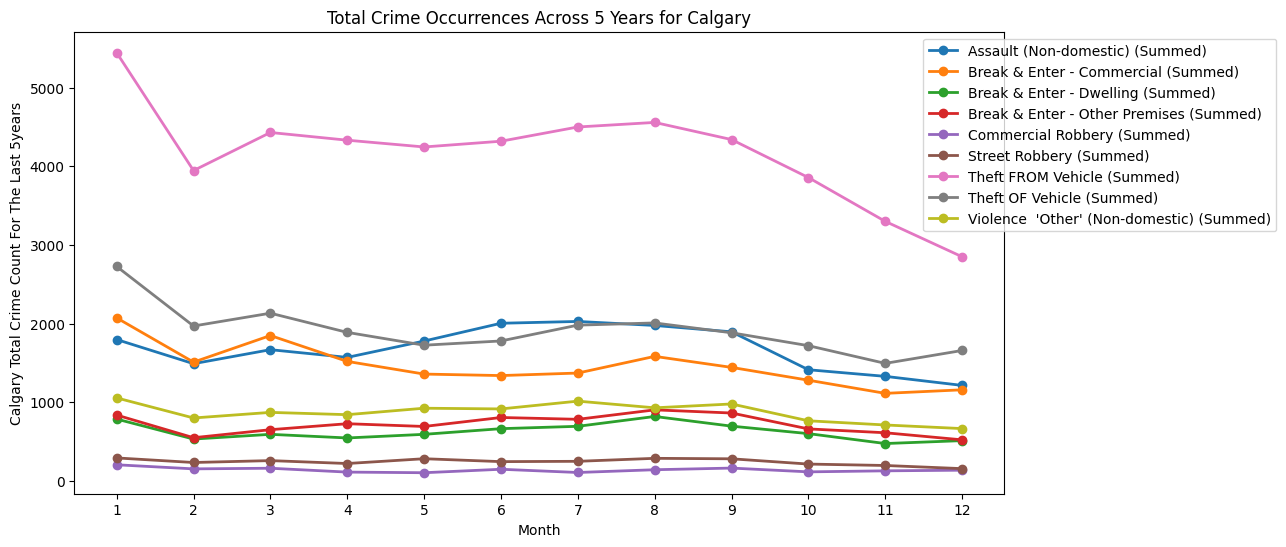

In [17]:
plot_crime_summary_series_all_years(calgary_extended_df, years_in_view, city="Calgary")

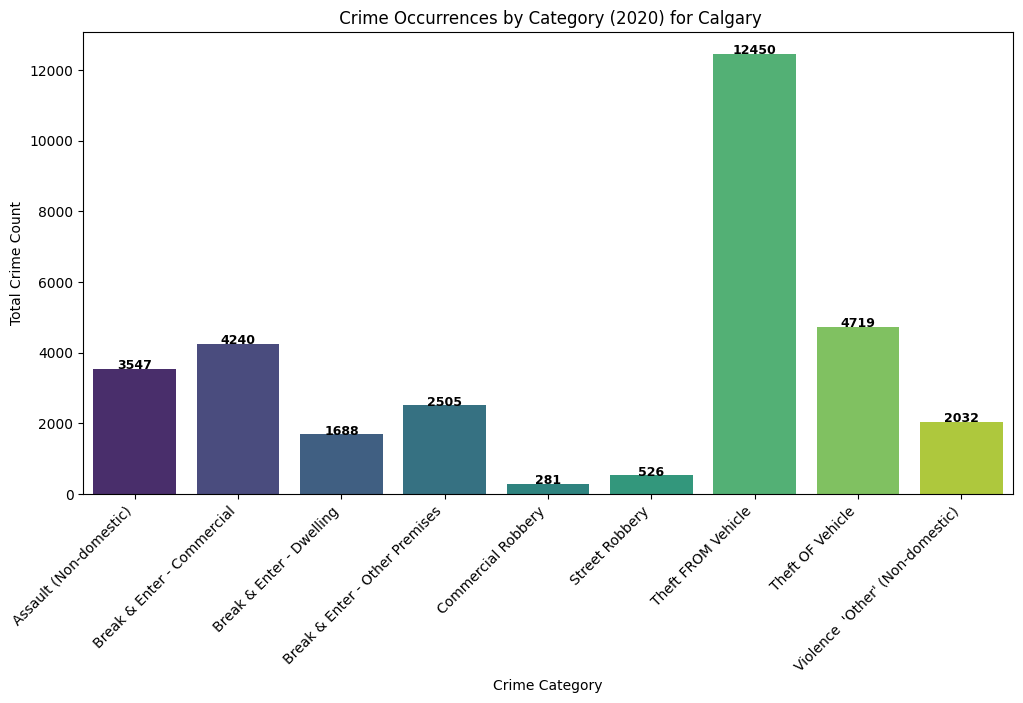

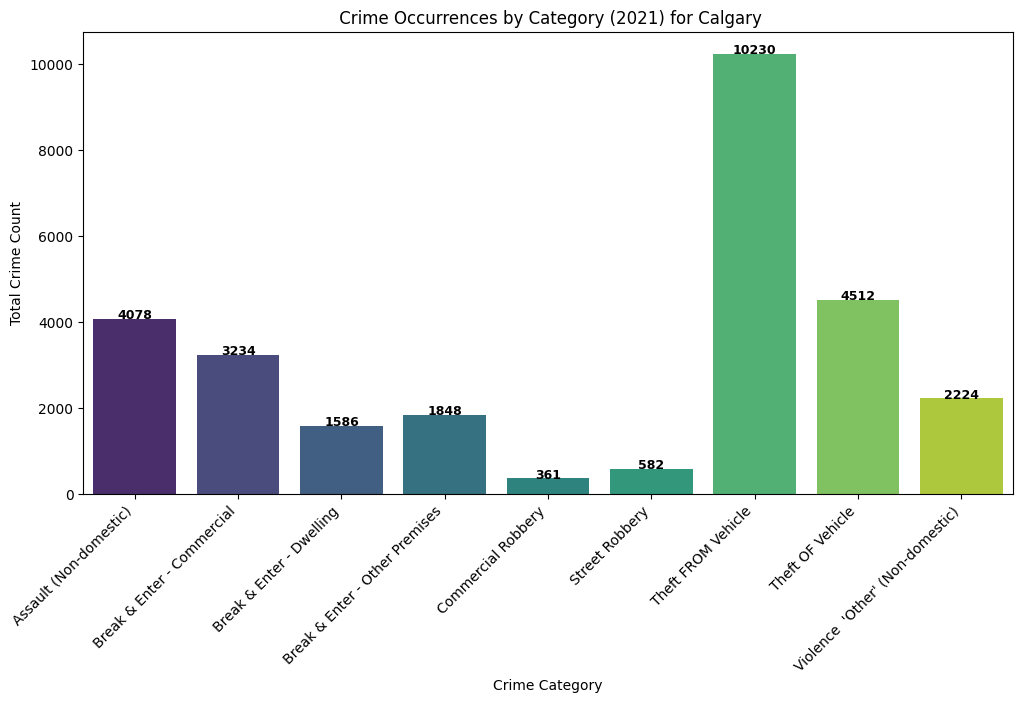

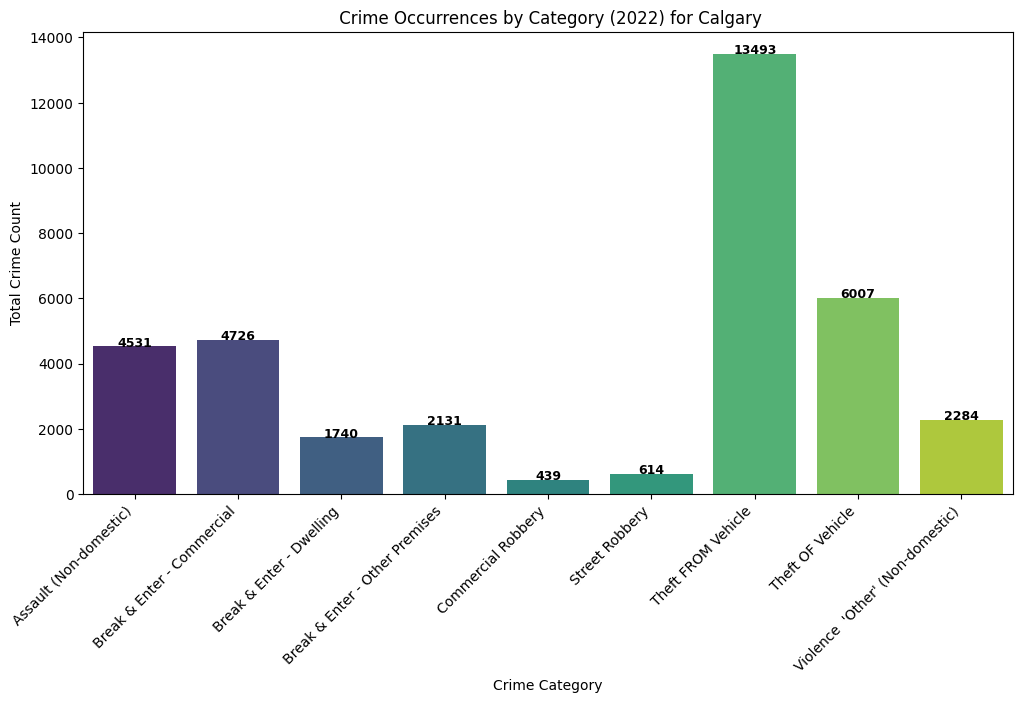

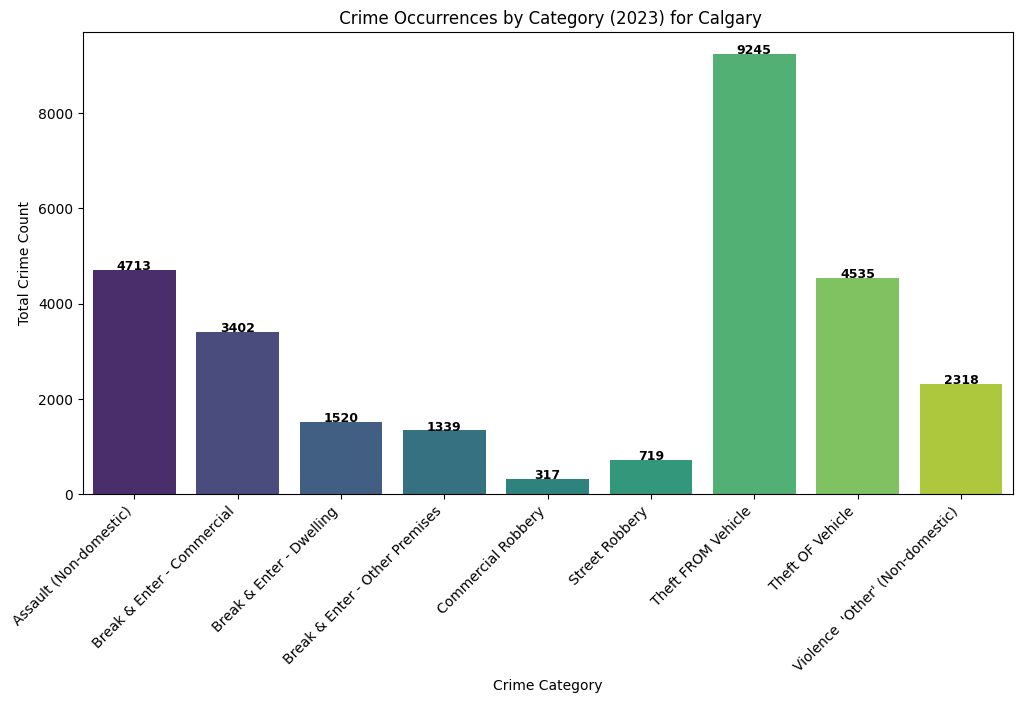

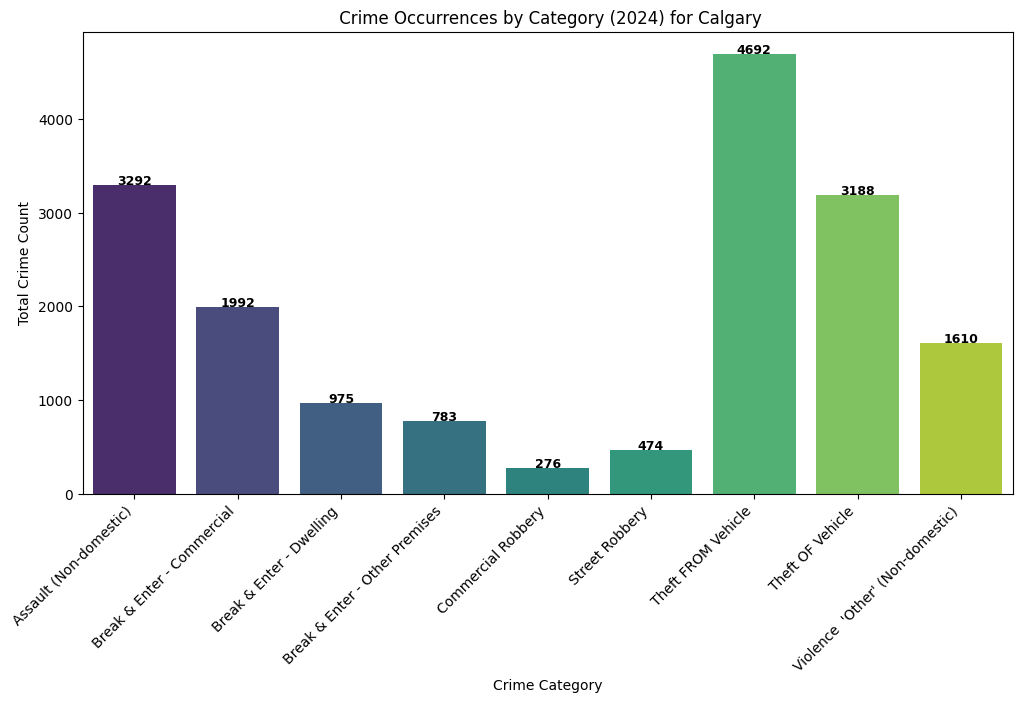

In [18]:
plot_crime_occurrence_barchart(calgary_extended_df, years_in_view, city="Calgary")

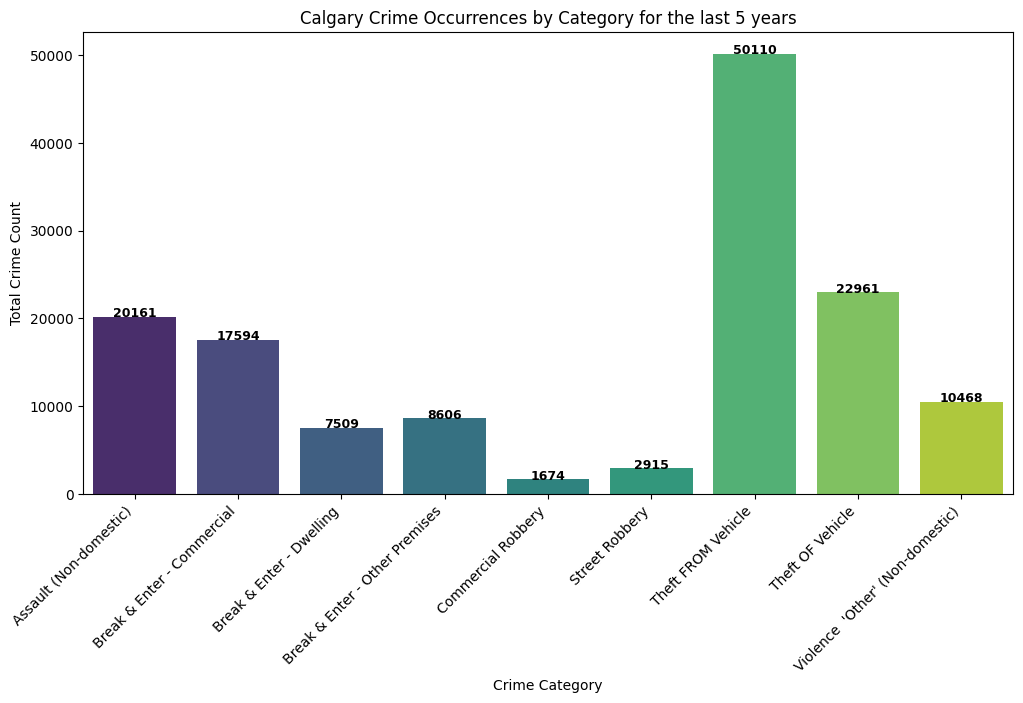

In [19]:
plot_crime_summary_barchart_all_years(calgary_extended_df, years_in_view, city="Calgary")

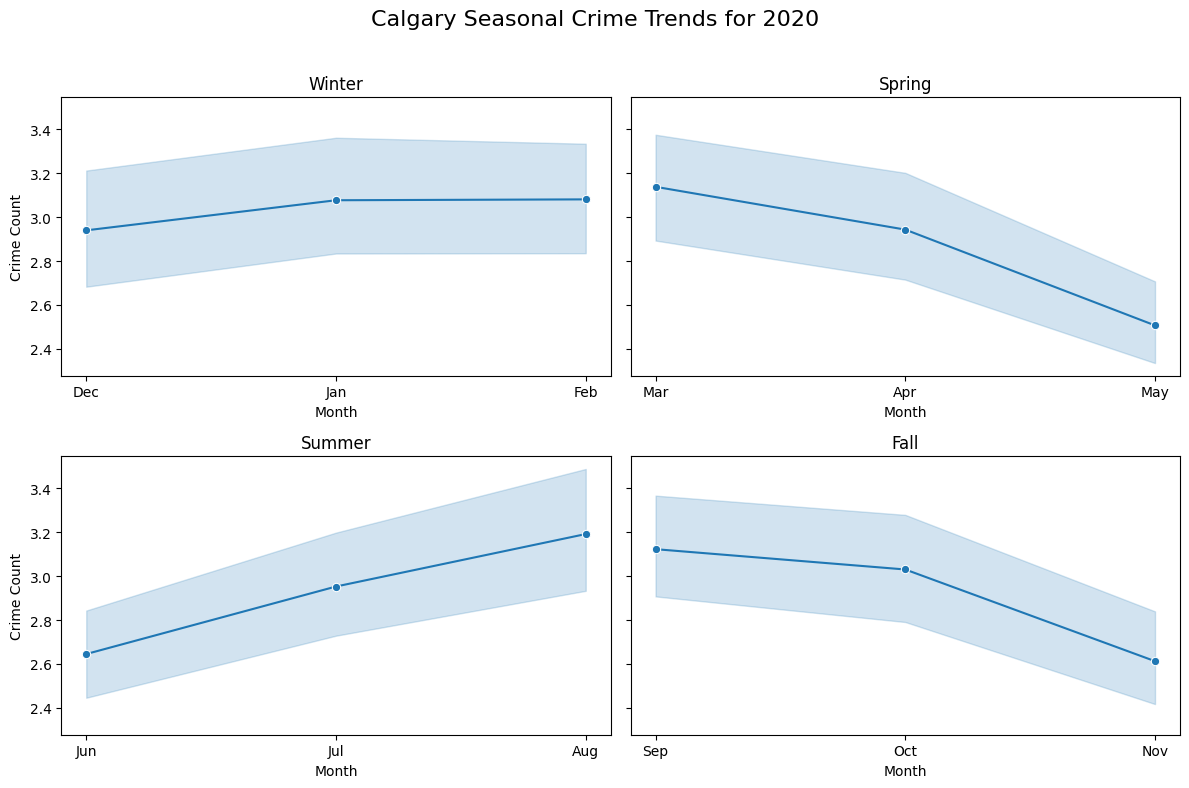

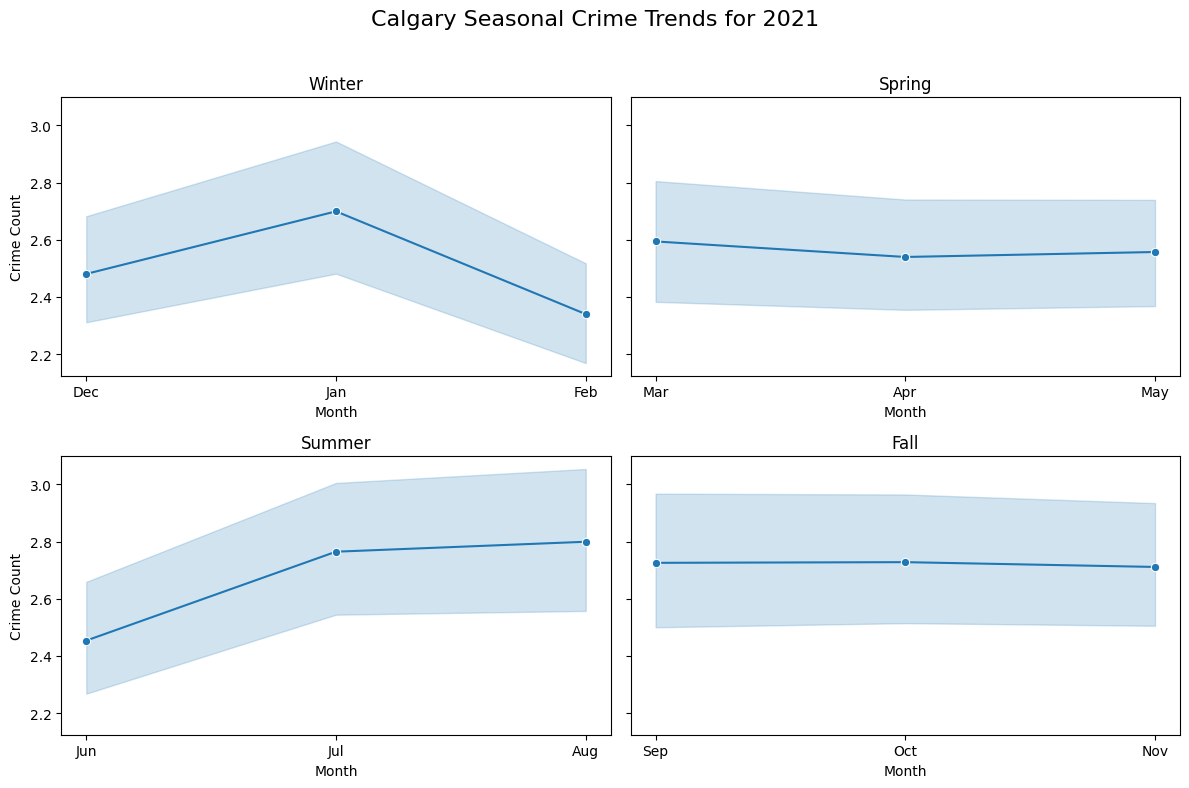

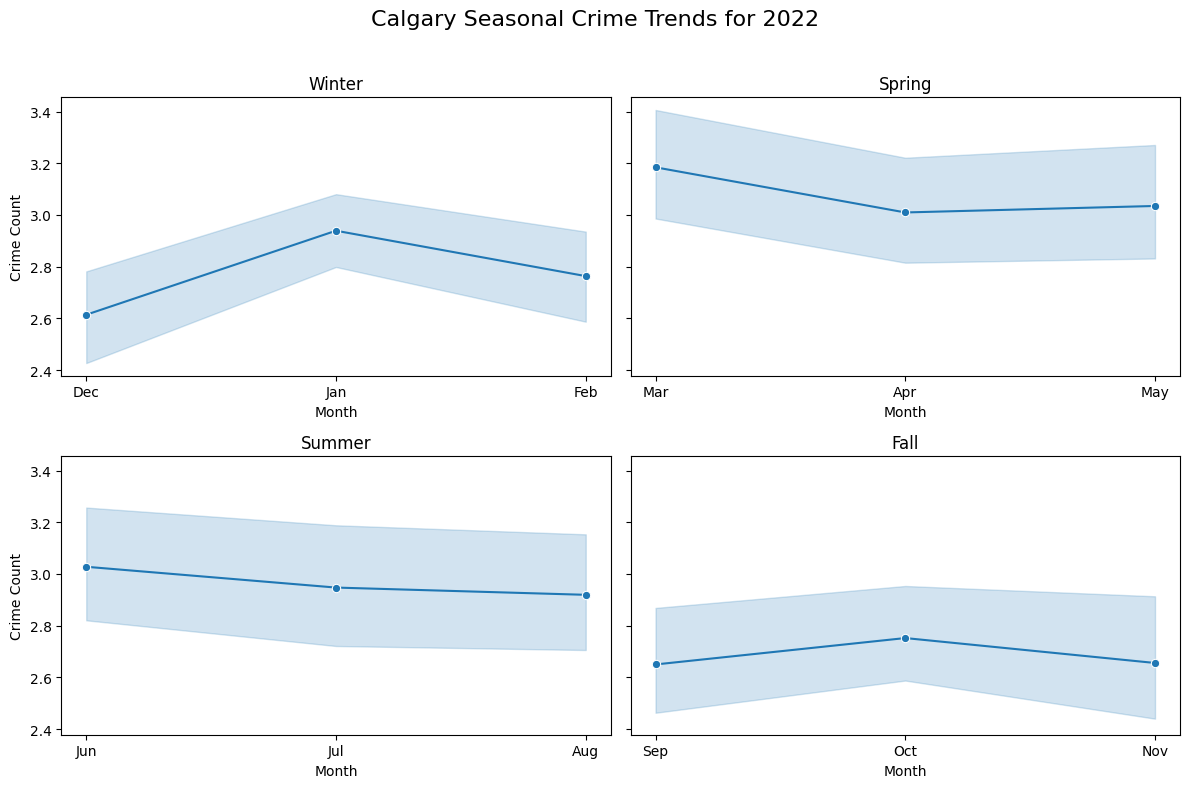

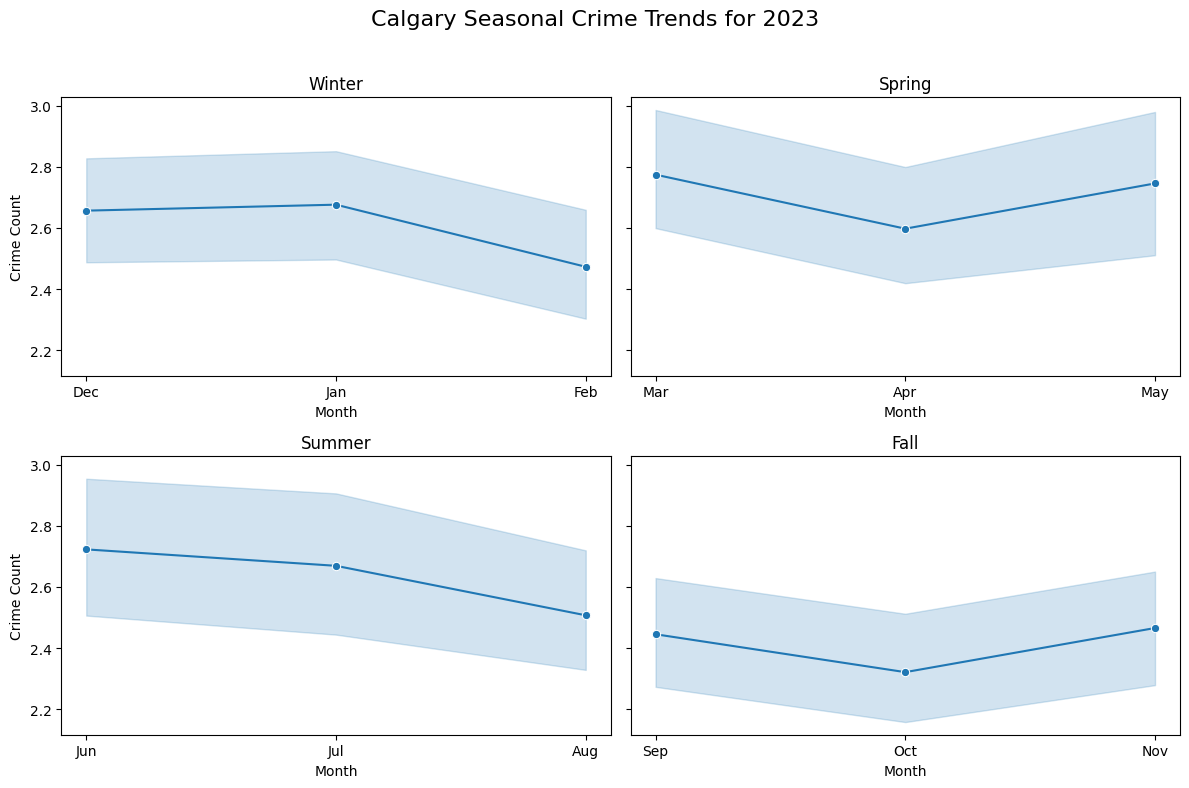

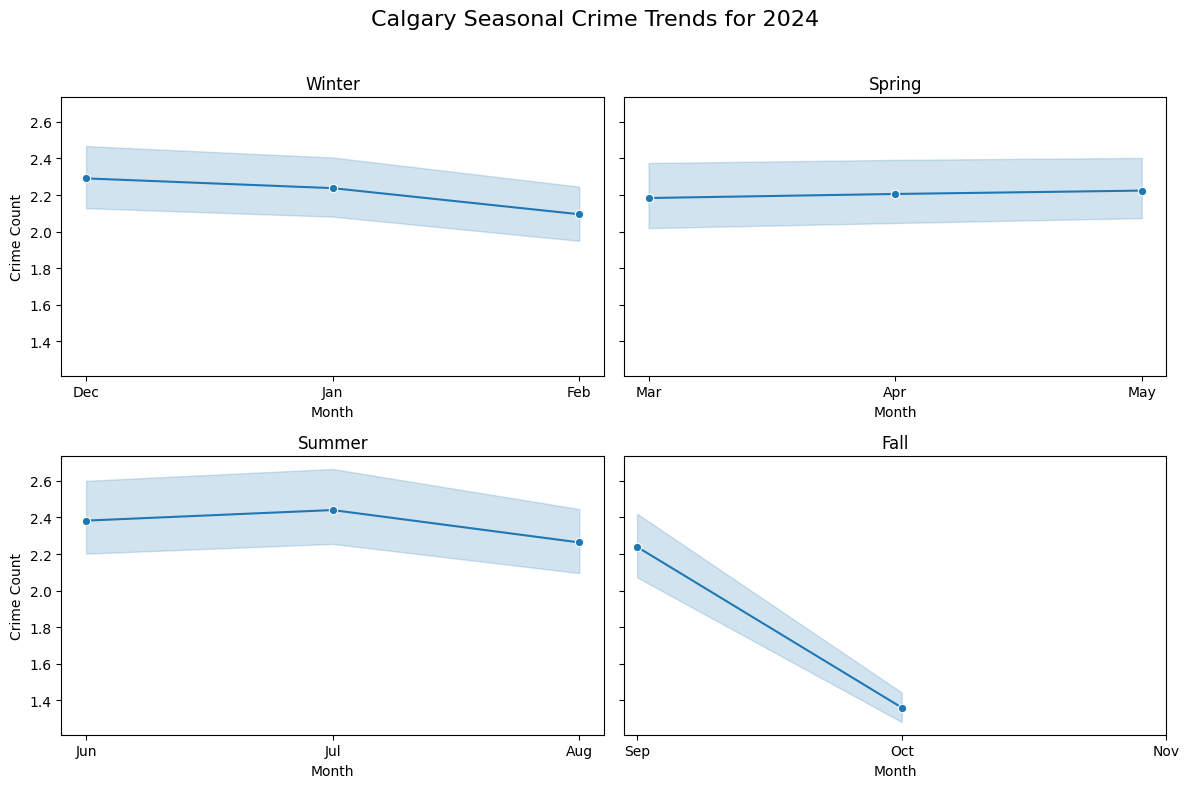

In [20]:
plot_seasonal_crime_occurrence_series(calgary_extended_df, years_in_view, city="Calgary")

C:\Users\Ravin\AppData\Local\Temp\ipykernel_20552\1923480915.py:264: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, "Crime Count"))


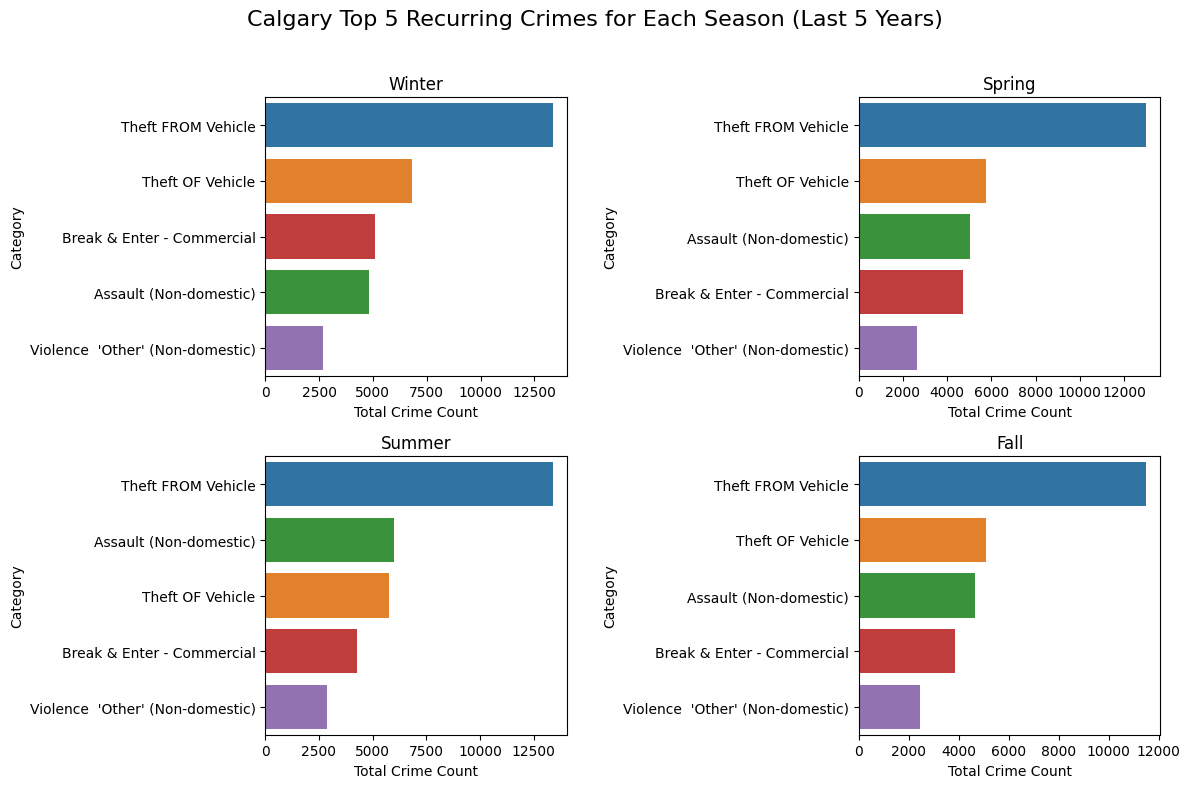

In [21]:
plot_top_seasonal_crime_occurrence_over_years(calgary_extended_df, years_in_view, city="Calgary")

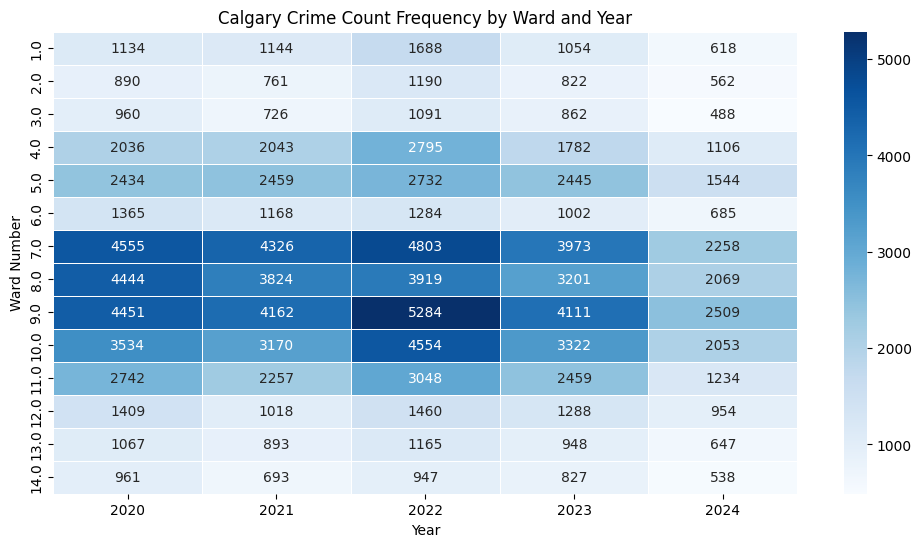

In [22]:
plot_wards_crime_occurrence_heatmap_over_years(calgary_extended_df, years_in_view, city="Calgary")

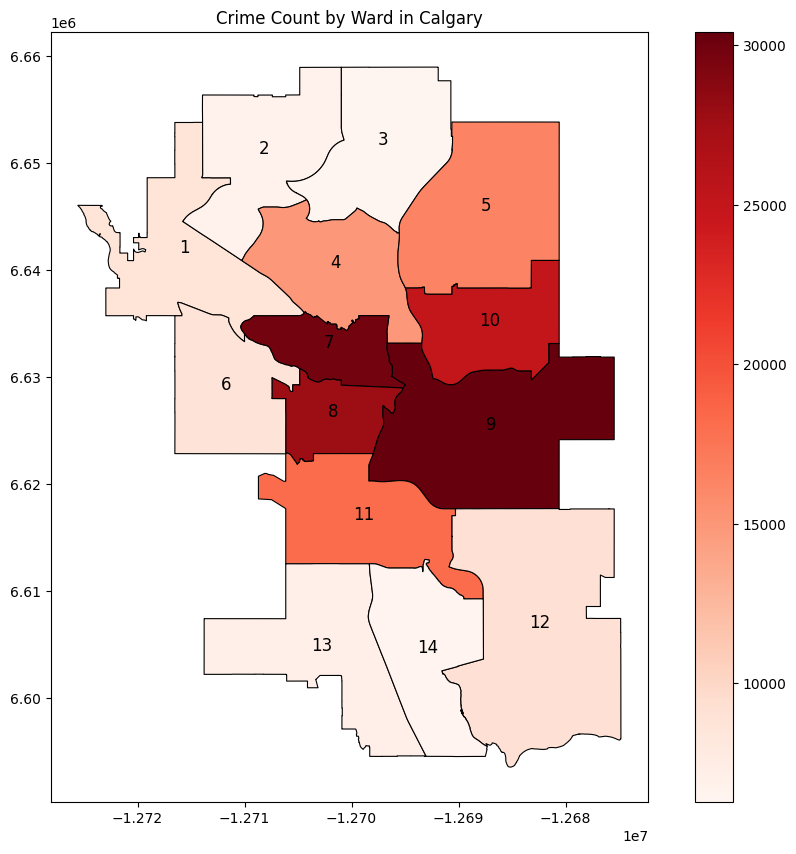

In [23]:
calgary_geo_df = prepare_city_geo_df("./geos/calgary_wards_geo.geojson")

display_city_crime_geo_data(calgary_geo_df, calgary_extended_df, "Calgary")

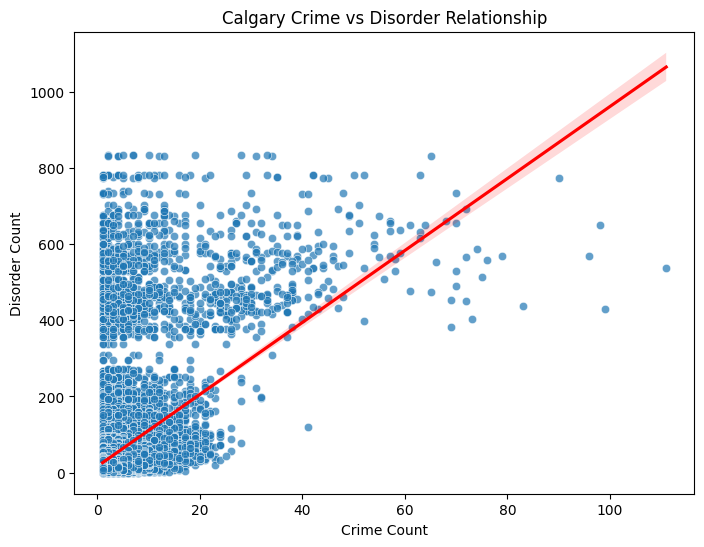

In [24]:
plot_city_crime_disorder_relationship(calgary_extended_df, "Calgary")

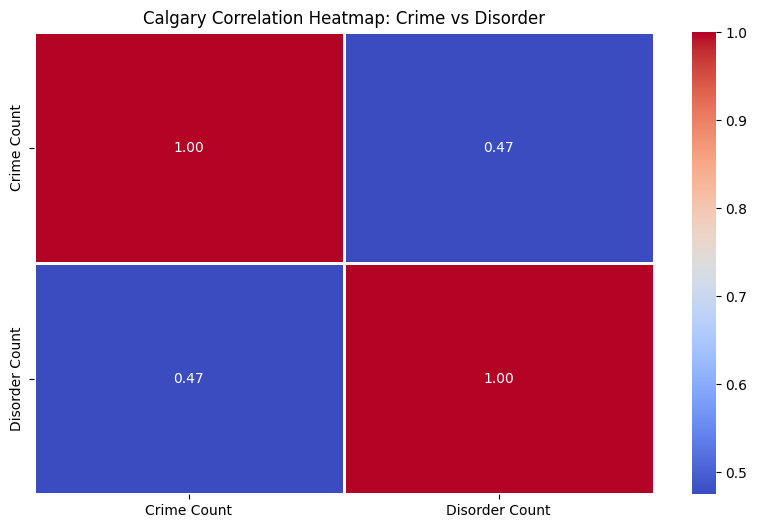

In [25]:
plot_city_crime_disorder_correlation(calgary_extended_df, "Calgary")